In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, TargetEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet,LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.exceptions import ConvergenceWarning

sys.path.append('../src')
from preprocess import data

warnings.filterwarnings("ignore", category=ConvergenceWarning)



In [2]:
data

,area_type,availability,location,size,society,total_sqft,price,bath,balcony
0,super built-up area,19-dec,electronic city phase ii,2 bhk,coomee,1056,39.07,2,1
1,plot area,ready to move,chikka tirupathi,4 bedroom,theanmp,2600,120.00,5,3
2,built-up area,ready to move,uttarahalli,3 bhk,unknown,1440,62.00,2,3
3,super built-up area,ready to move,lingadheeranahalli,3 bhk,soiewre,1521,95.00,3,1
4,super built-up area,ready to move,kothanur,2 bhk,unknown,1200,51.00,2,1
...,...,...,...,...,...,...,...,...,...
13314,super built-up area,ready to move,green glen layout,3 bhk,soosepr,1715,112.00,3,3
13315,built-up area,ready to move,whitefield,5 bedroom,arsiaex,3453,231.00,4,0
13316,super built-up area,ready to move,richards town,4 bhk,unknown,3600,400.00,5,2
13317,built-up area,ready to move,raja rajeshwari nagar,2 bhk,mahla t,1141,60.00,2,1


<class 'pandas.core.frame.DataFrame'>
Index: 12789 entries, 0 to 13318
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12789 non-null  object 
 1   availability  12789 non-null  object 
 2   location      12789 non-null  object 
 3   size          12789 non-null  object 
 4   society       12789 non-null  object 
 5   total_sqft    12789 non-null  object 
 6   price         12789 non-null  float64
 7   bath          12789 non-null  int32  
 8   balcony       12789 non-null  int32  
dtypes: float64(1), int32(2), object(6)
memory usage: 899.2+ KB


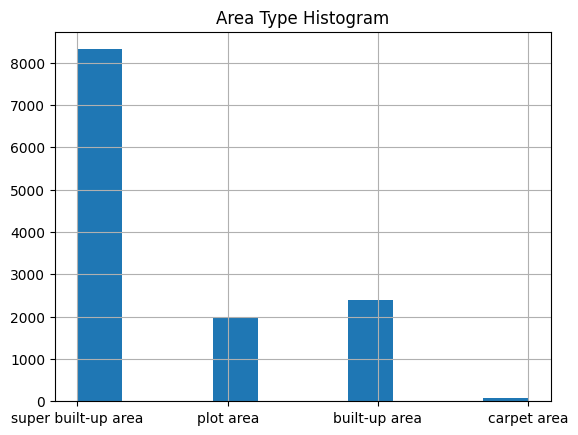

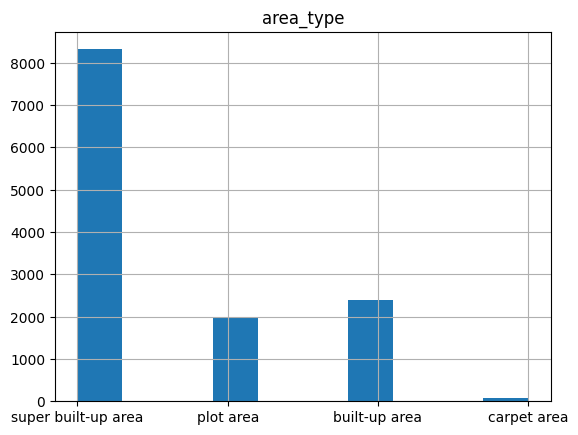

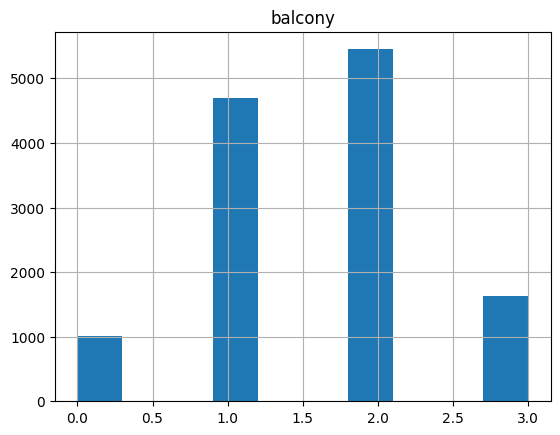

price         1.000000
total_sqft    0.574001
bath          0.451185
bhk           0.395103
balcony       0.123590
Name: price, dtype: float64


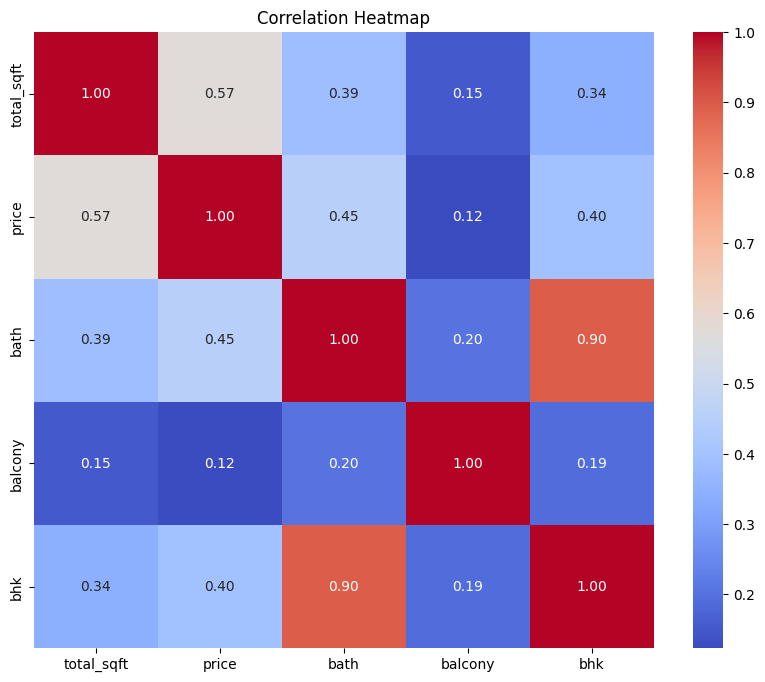

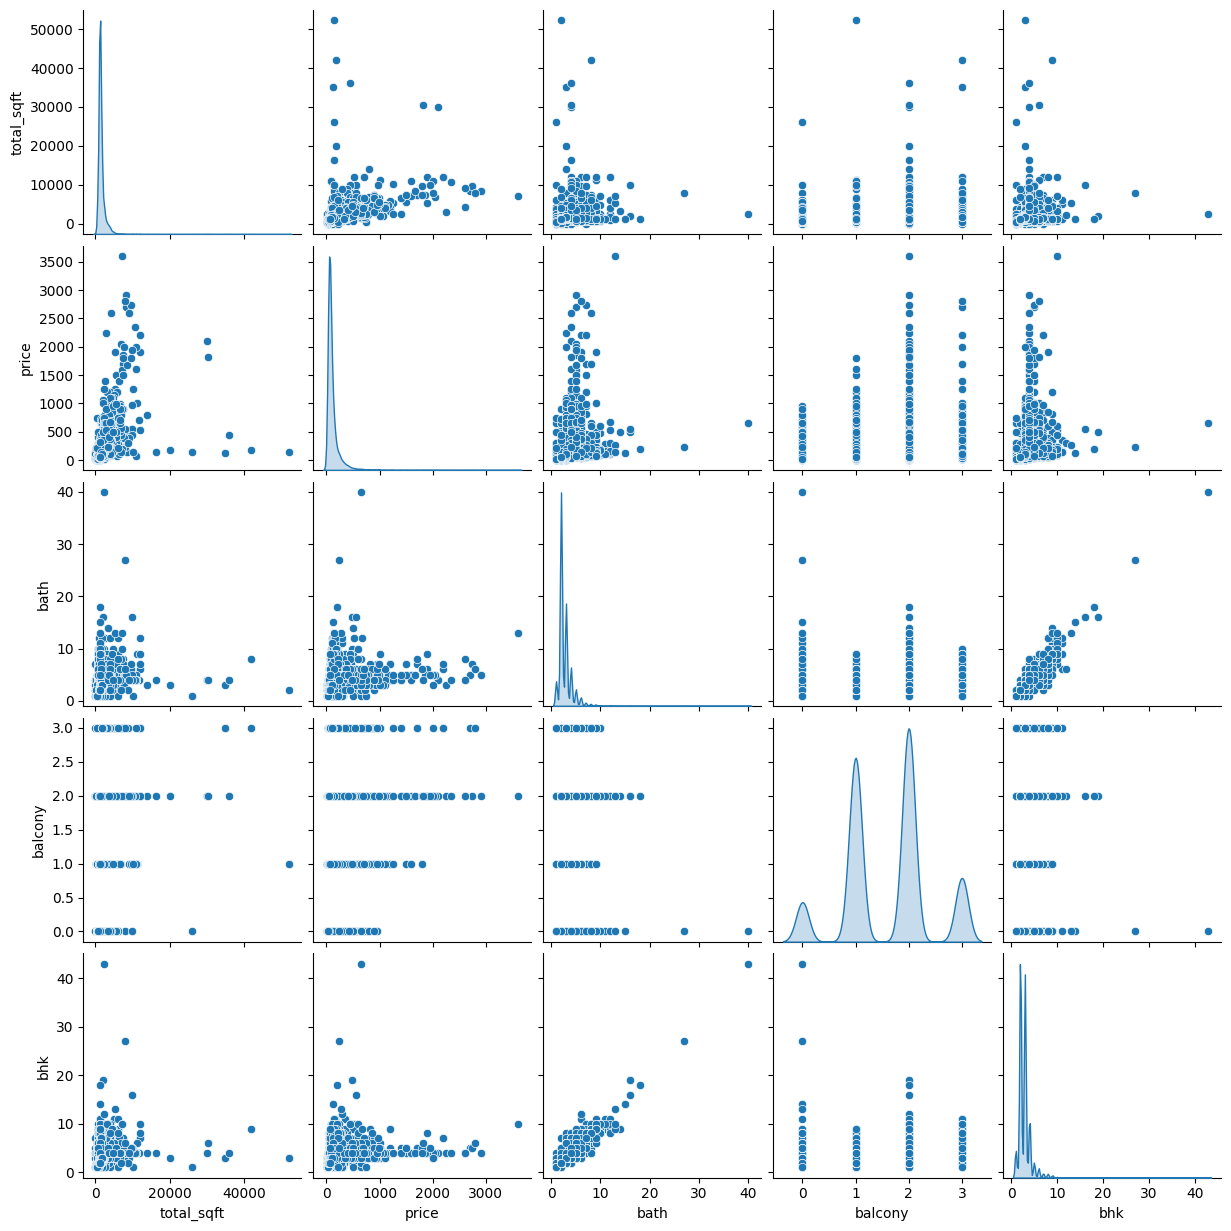

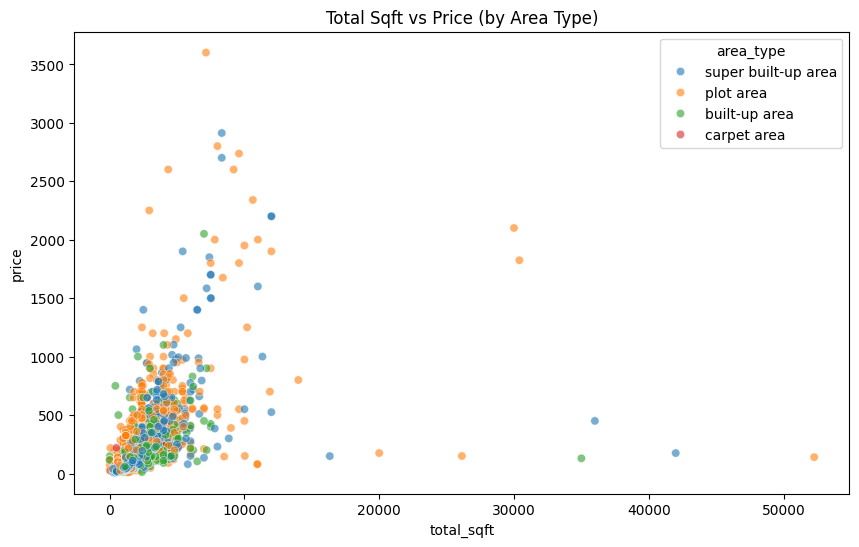

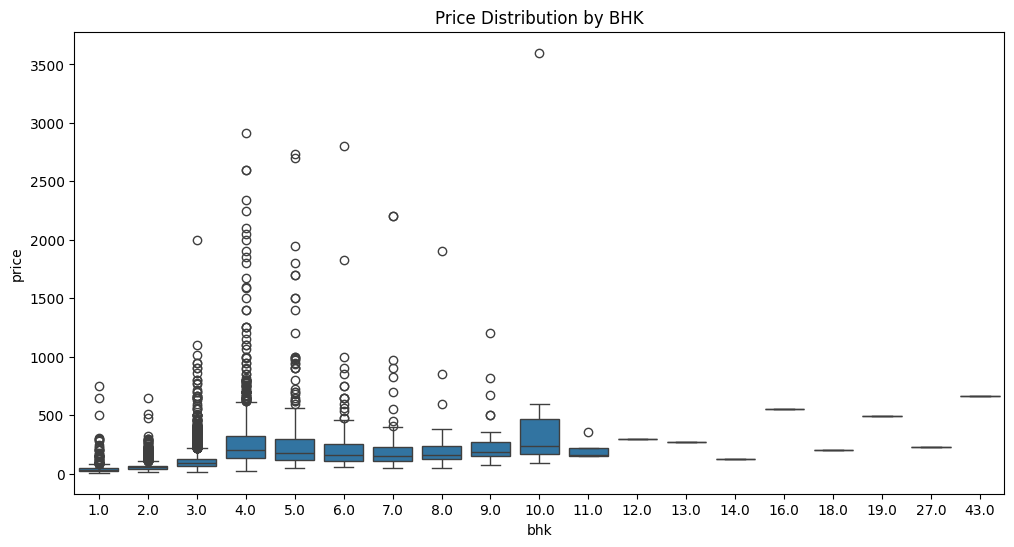

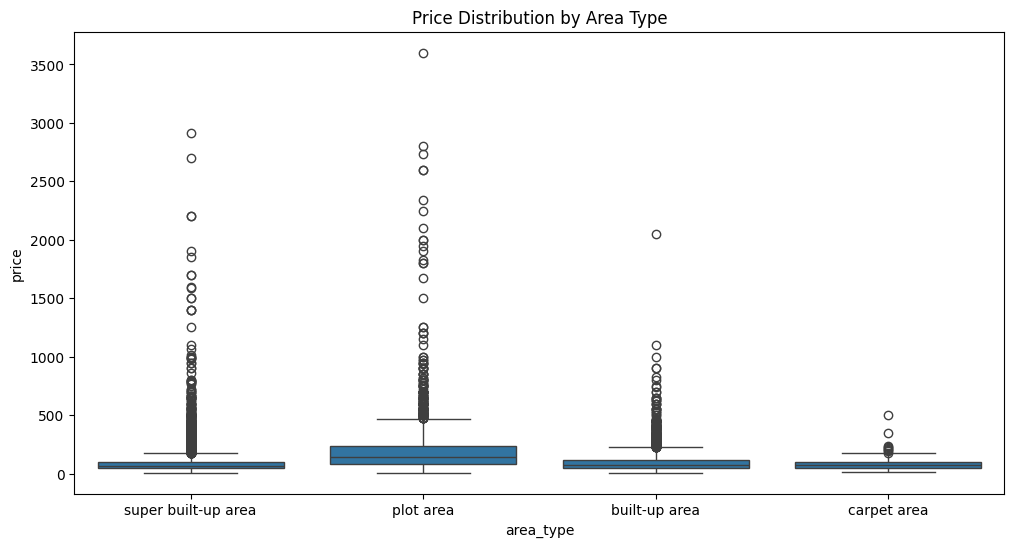

Baseline RMSE: 151.48421513777996


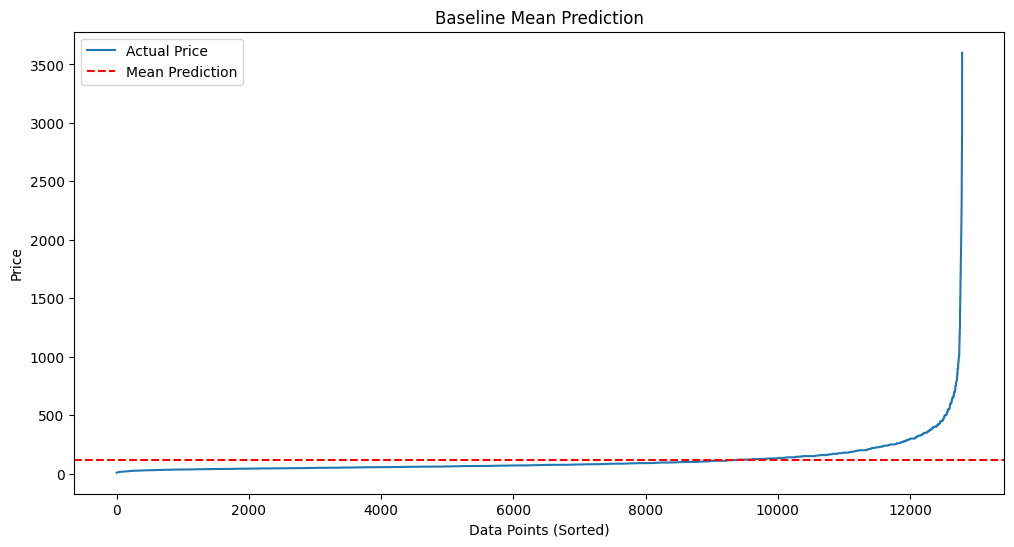

In [3]:


data.info()

data['area_type'].hist()
plt.title('Area Type Histogram')
plt.show()

for col in data.columns:
    if data[col].nunique() < 10:
        plt.figure()
        try:
            data[col].hist()
            plt.title(col)
            plt.show()
        except:
            pass

def convert_sqft(x):
    try:
        if '-' in str(x):
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft)
data['bhk'] = data['size'].str.extract(r'(\d+)').astype(float)

numeric_data = data.select_dtypes(include=['number'])
corr_matrix = numeric_data.corr()

print(corr_matrix['price'].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

sns.pairplot(data.select_dtypes(include=['number']), diag_kind='kde')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_sqft', y='price', hue='area_type', data=data, alpha=0.6)
plt.title('Total Sqft vs Price (by Area Type)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='bhk', y='price', data=data)
plt.title('Price Distribution by BHK')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='area_type', y='price', data=data)
plt.title('Price Distribution by Area Type')
plt.show()

# --- Baseline Prediction ---
y_base = data['price']
y_pred_base = np.full(len(y_base), y_base.mean())
rmse_base = np.sqrt(mean_squared_error(y_base, y_pred_base))
print(f"Baseline RMSE: {rmse_base}")

plt.figure(figsize=(12, 6))
plt.plot(data['price'].sort_values().reset_index(drop=True), label='Actual Price')
plt.axhline(y=data['price'].mean(), color='r', linestyle='--', label='Mean Prediction')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Data Points (Sorted)')
plt.title('Baseline Mean Prediction')
plt.show()



In [4]:

num_cols_fill = data.select_dtypes(include=['number']).columns
data[num_cols_fill] = data[num_cols_fill].fillna(data[num_cols_fill].mean())

print(data.isnull().sum())

def find_outliers(df):
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            print(f"--- {col} --- Count: {len(outliers)}")

find_outliers(data)

data = data[~(data['total_sqft'] / data['bhk'] < 300)].copy()

clip_cols = ['total_sqft', 'bath', 'bhk', 'price']
for col in clip_cols:
    low, high = data[col].quantile([0.01, 0.99])
    data[col] = np.clip(data[col], low, high)

print(data.shape)
print(data[clip_cols].describe())



area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
price           0
bath            0
balcony         0
bhk             0
dtype: int64
--- total_sqft --- Count: 1140
--- price --- Count: 1257
--- bath --- Count: 1032
--- bhk --- Count: 839
(12051, 10)
         total_sqft          bath           bhk         price
count  12051.000000  12051.000000  12051.000000  12051.000000
mean    1566.552024      2.554560      2.646178    108.512233
std      808.595693      1.005333      0.908643    110.601118
min      520.000000      1.000000      1.000000     19.500000
25%     1120.000000      2.000000      2.000000     49.975000
50%     1309.000000      2.000000      3.000000     70.000000
75%     1713.000000      3.000000      3.000000    120.000000
max     5129.000000      6.000000      6.000000    700.000000


In [5]:


cat_cols = data.select_dtypes(include=['object']).columns
ohe_cols = [col for col in cat_cols if data[col].nunique() < 10]
target_cols = [col for col in cat_cols if data[col].nunique() >= 10]
num_cols = ['total_sqft', 'bath', 'bhk', 'balcony']

X_master = data[num_cols + ohe_cols + target_cols]
y_master = data['price']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('ohe', ohe_pipeline, ohe_cols),
        ('target', target_pipeline, target_cols)
    ]
)



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, test_size=0.2, random_state=42)
X_train_proc = preprocessor.fit_transform(X_train, y_train)
X_test_proc = preprocessor.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train)

y_train_pred = lin_reg.predict(X_train_proc)
y_test_pred = lin_reg.predict(X_test_proc)

print(f"Train R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test R2 Score: {r2_score(y_test, y_test_pred):.4f}")




Train R2 Score: 0.7209
Test R2 Score: 0.7316


In [7]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_master, y_master, test_size=0.2, random_state=42)
X_train_proc_final = preprocessor.fit_transform(X_train_final, y_train_final)
X_test_proc_final = preprocessor.transform(X_test_final)

pipeline_final = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

pipeline_final.fit(X_train_proc_final, y_train_final)

y_train_pred_final = pipeline_final.predict(X_train_proc_final)
y_test_pred_final = pipeline_final.predict(X_test_proc_final)

print(f"Train R2 Score: {r2_score(y_train_final, y_train_pred_final):.4f}")
print(f"Test R2 Score: {r2_score(y_test_final, y_test_pred_final):.4f}")

Train R2 Score: 0.7544
Test R2 Score: 0.7481


In [8]:
from sklearn.pipeline import Pipeline
import pickle

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

full_pipeline.fit(X_train_final, y_train_final)

with open('../models/models.pkl', 'wb') as f:
    pickle.dump(full_pipeline, f)

In [9]:
with open('../models/lin_reg.pkl', 'wb') as f:
    pickle.dump(lin_reg, f)